<a href="https://colab.research.google.com/github/mchivuku/CSCI-B657-CV-Labs/blob/master/Computer_Vision_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab 3 - Harris Detection **

What to do
Write a Python program to do the following:
1. Given an input image, your program should rst convert it to grayscale.
2. Calculate the partial derivative of the image in the x and y directions. You can do this by convolving
the grayscale image with a lter that looks like

−1 1
for the x direction and

−1
1

for the y direction. Let us call the results of these convolutions Ix and Iy, respectively.
3. Let I
2
x = Ix × Ix
4. Let IxIy = Ix × Iy
5. Let I
2
y = Iy × Iy
6. Calculate AW , BW , CW by convolving I
2
x
, IxIy, I
2
y with a box lter, such as


1 1 1
1 1 1
1 1 1


7. Compute the eigenvalues of

AW BW
BW CW

at each pixel and only keep those where min(λ1, λ2) > T where T is some threshold.
8. Visually mark the detected corners from the previous step on top of the original image. Save the
output to a le.
9. Optional Apply non-maximal suppression on the results from the step 7 to avoid multiple detections

In [0]:
import numpy as np
import imageio
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt
import scipy.fftpack as F2

from matplotlib.colors import LogNorm

%matplotlib inline

plt.style.use("fivethirtyeight")


In [4]:
## Mount google drive

from google.colab import drive

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd /content/drive/My\ Drive/Masters-DS/Computer-Vision/labs/lab3
%ls

/content/drive/My Drive/Masters-DS/Computer-Vision/labs/lab3
image.png  lab_3.pdf


In [0]:
## functions
## Helper functions - read image, perform FFT
"""
Read image and convert to grayscale
"""
def read_image(file):
  image = Image.open(file).convert("L")
  return image

"""
Show image
"""
def show_image(image):
  plt.imshow(np.array(image).astype(np.uint8))
  plt.axis('off')
  plt.show()
  


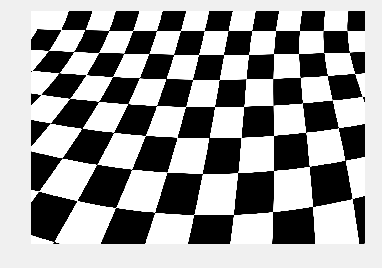

In [7]:
image = read_image("image.png")
show_image(image)

In [0]:
gradient_x = np.array([[0,0,0],[-1,1,0],[0,0,0]])
gradient_y = np.array([[0,-1,0],[0,1,0],[0,0,0]])



In [0]:
## convolution
compute_padding = lambda f: int ( (f - 1) / 2 )
def convolve( image, filter ):
    m, n = filter.shape
    if m != n:
        raise Exception ( "Kernel is not symmetric" )
    else:
        h, w = image.shape
        h_new, w_new = h - m + 1, w - m + 1
        new_image = np.zeros ( shape=(h_new, w_new) )
        output = np.zeros ( shape=(h, w) )
        padding = compute_padding ( m )
        for i in range ( h_new ):
            for j in range ( w_new ):
                new_image[i, j] = np.sum ( image[i:i + m, j:j + m] * filter )

        output[padding:-padding, padding:-padding] = new_image
        return output
      
image = np.array(image)
I_x = convolve(image,gradient_x)
I_y = convolve(image,gradient_y)

  

In [0]:
def normalize(vector):
  base = np.min(vector)
  roof = np.max(vector)
  diff = roof - base
  scale = diff/255
  vector = vector - base
  return vector//scale

I_x = normalize(I_x)
I_y = normalize(I_y)



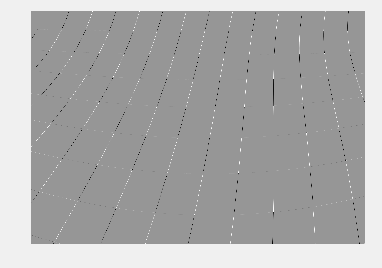

In [11]:
show_image(I_x)

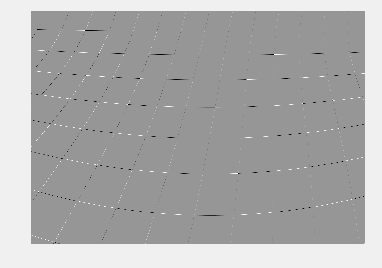

In [12]:
show_image(I_y)

In [0]:
I_x_sq = I_x * I_x
I_y_sq = I_y * I_y
I_xy = I_x * I_y

I_x_sq = normalize(I_x_sq)
I_y_sq = normalize(I_y_sq)
I_xy = normalize(I_xy)

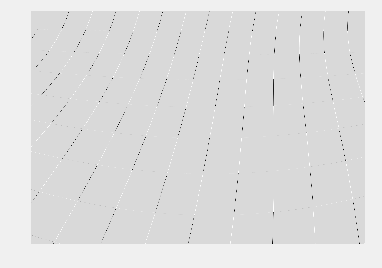

In [14]:
show_image(I_x_sq)

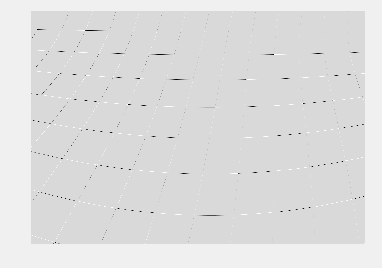

In [15]:
show_image(I_y_sq)

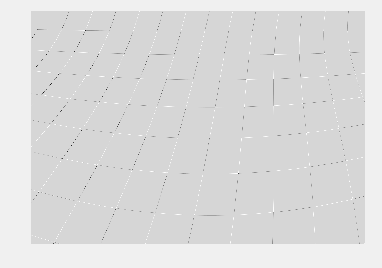

In [16]:
show_image(I_xy)

In [17]:
box_filter = np.ones(shape=(3,3))
box_filter

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [0]:
#AW, BW, CW by convolving I2x, IxIy, I2y with
A_w = convolve(I_x_sq,box_filter)
A_w = normalize(A_w)

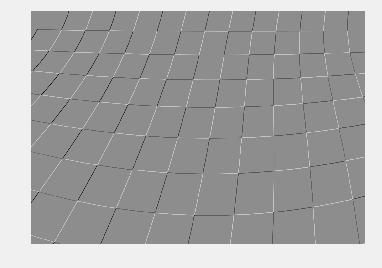

In [19]:

B_w = convolve(I_xy,box_filter)
B_w = normalize(B_w)
show_image(B_w)

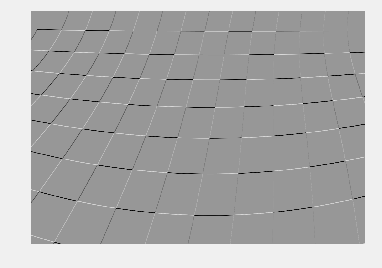

In [20]:
C_w = convolve(I_y_sq,box_filter)
C_w = normalize(C_w)
show_image(C_w)

In [0]:
#Compute the eigenvalues of  AW BW BW CW , at each pixel and only keep those where min(λ1, λ2) > T where T is some threshold.

  
"""
Compute eigen values
"""
def compute_eigen_values_vector(Aw,Bw,Cw,y,x):
  eigen_values , eig_vectors = np.linalg.eig(np.array([[Aw[y][x],Bw[y][x]],[Bw[y][x],Cw[y][x]]]))
  ## sort eigen pairs
  eig_pairs = [(( eigen_values[i] ), eig_vectors[:, i]) for i in range ( len ( eigen_values ) )]
  eig_pairs.sort ( key=lambda x: x[0], reverse=True )
  
  # extract top two eigen values
  two_eigen_values = [(eig_pairs[i][0]) for i in range ( 2 )]
  return min(two_eigen_values) ## get min eigen value


h, w = image.shape
coords = np.zeros(image.shape)
for i in range(h):
  for j in range(w):
    coords[i,j] = compute_eigen_values_vector(A_w,B_w,C_w,i,j)
    
corner_threshold = np.max(coords)

In [117]:
print("Corner threshold", corner_threshold)
threshold  = 0.1
corn_threshold = corner_threshold*threshold
harris_corners =  (coords>corn_threshold)*1

Corner threshold 22.497881393970268


In [118]:
## Draw on detected corner:
non_zero_values = np.array(harris_corners.nonzero()).T
non_zero_values.shape

(17550, 2)

In [0]:
im = Image.open("image.png")
draw = ImageDraw.Draw(im)
def draw_lines(draw,y,x):
  left = (x-1,y)
  right = (x+1,y)
  top = (x,y-1)
  bottom = (x,y+1)
  draw.line([left, right], fill=(255,0,0), width=2)
  draw.line([top, bottom], fill=(255,0,0), width=2)



In [0]:
for i in range(non_zero_values.shape[0]):
  y, x = non_zero_values[i,0],non_zero_values[i,1]
  draw_lines(draw,y,x)


(-0.5, 1399.5, 979.5, -0.5)

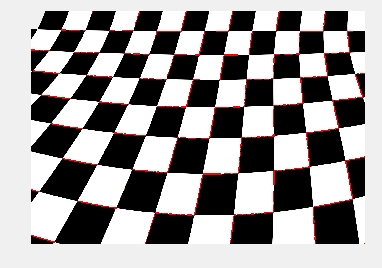

In [121]:
plt.imshow(im)
plt.axis('off')